In [24]:
import json
import numpy as np
import os
import copy
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern


%matplotlib inline  


In [5]:
runs_dir = "/Users/martinweiss/PycharmProjects/tn-learn/info-bazaar/friday-runs"
experiment_names = ["llama-70b-10q", "gpt-3.5-10q", "llama-7b-10q", "llama-13b-10q", "gpt-4-10q",]


In [6]:
summaries = defaultdict(list)
evaluations = defaultdict(list)
all_data = []

for experiment_name in experiment_names:
    exp_base_dir = os.path.join(runs_dir, experiment_name)
    seed_dirs = [d for d in os.listdir(exp_base_dir) if os.path.isdir(os.path.join(exp_base_dir, d))]

    for seed in tqdm(seed_dirs):
        seed_dir = os.path.join(exp_base_dir, seed)
        summary_path = os.path.join(seed_dir, "bazaar_summary.json")
        evaluation_path = os.path.join(seed_dir, "evaluation.json")
        try:
            with open(summary_path, "r") as f:
                summary = json.load(f)
            with open(evaluation_path, "r") as f:
                evaluation = json.load(f)

            num_blocks = {b['principal']['name']: len(b['principal']['answer']['blocks']) for b in summary['buyer_agents'] if b['principal']['answer'] is not None}

            for b in evaluation['buyer_agents']:
                flattened = {'experiment_name': experiment_name, 'seed': seed}
                for k, v in b.items():
                    if isinstance(v, dict):
                        for sub_k, sub_v in v.items():
                            flattened[f"{k}/{sub_k}"] = sub_v
                    else:
                        flattened[k] = v
                flattened['num_block'] = num_blocks.get(b['name'], None)
                all_data.append(flattened)

        except FileNotFoundError:
            pass
# Create a DataFrame
df = pd.DataFrame(all_data)
df['budget_used'] = df['max_budget'] - df['credit_left']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.70it/s]


In [16]:
csv_path = "friday_dataframe.csv" 
df.to_csv(csv_path, index=False)

In [19]:
# Full code to load the original DataFrame, filter it, expand it, and save the expanded DataFrame to a new CSV file

def load_and_filter_dataframe(csv_path):
    df = pd.read_csv(csv_path)
    return df.dropna(subset=['question_text', 'open_book_answer', 'closed_book_answer', 'answer_text'])

def expand_rows_with_question(df):
    expanded_data = []
    for idx, row in df.iterrows():
        question_content = row['question_text']
        for answer_type in ['Open Book Answer', 'Closed Book Answer', 'Answer Text']:
            answer_content = row.get(answer_type.lower().replace(' ', '_'), None)
            if pd.notna(answer_content):
                expanded_row = row.copy()
                expanded_row['text'] = {
                    'Question': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Question">{question_content}</span>',
                    'Answer': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: {answer_type}, {row.get("experiment_name")}">{answer_content}</span>'
                }
                expanded_data.append(expanded_row)
    return pd.DataFrame(expanded_data)

# Load and filter the DataFrame
filtered_df = load_and_filter_dataframe(csv_path)

# Expand the rows, include the question, and reset index
expanded_df_with_question = expand_rows_with_question(filtered_df)
expanded_df_with_question.reset_index(drop=True, inplace=True)

# Write DataFrame to new CSV file
output_csv_path_expanded_with_question = '~/Downloads/reformatted_dataframe_expanded.csv'
expanded_df_with_question.to_csv(output_csv_path_expanded_with_question, index=False)

output_csv_path_expanded_with_question



'formatted_dataframe_full_process.csv'

In [28]:
# Full code to load the original DataFrame, filter it, anonymize and shuffle the answers, and save it to a new CSV file

def load_and_filter_dataframe(csv_path):
    df = pd.read_csv(csv_path)
    return df.dropna(subset=['question_text', 'open_book_answer', 'closed_book_answer', 'answer_text'])

def shuffle_and_map_answers_with_context(input_dict):
    keys = list(input_dict.keys())
    shuffled_keys = random.sample(keys, len(keys))
    shuffled_dict = {f"Answer {i+1}": input_dict[k] for i, k in enumerate(shuffled_keys)}
    key_mapping = {f"Answer {i+1}": k for i, k in enumerate(shuffled_keys)}
    return shuffled_dict, key_mapping

# Load and filter the DataFrame
filtered_df = load_and_filter_dataframe(csv_path)

# Shuffle keys, add context, and include the question
filtered_df['text_and_mapping'] = filtered_df.apply(lambda row: {
    'text': {'Question': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Question">{row["question_text"]}</span>', **shuffle_and_map_answers_with_context({
        'Open Book Answer': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Open Book Answer  {row.get("experiment_name")}">{row["open_book_answer"]}</span>',
        'Closed Book Answer': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Closed Book Answer  {row.get("experiment_name")}">{row["closed_book_answer"]}</span>',
        'Answer Text': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Answer Text  {row.get("experiment_name")}">{row["answer_text"]}</span>'
    })[0]},
    'mapping': shuffle_and_map_answers_with_context({
        'Open Book Answer': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Open Book Answer">{row["open_book_answer"]}</span>',
        'Closed Book Answer': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Closed Book Answer">{row["closed_book_answer"]}</span>',
        'Answer Text': f'<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Answer Text">{row["answer_text"]}</span>'
    })[1]
}, axis=1)

# Split the 'text_and_mapping' into separate columns for 'text' and 'mapping'
filtered_df[['text', 'mapping']] = filtered_df['text_and_mapping'].apply(pd.Series)

# Drop the combined column
filtered_df.drop(columns=['text_and_mapping'], inplace=True)

# Write DataFrame to new CSV file
output_csv_path_non_expanded = '~/Downloads/reformatted_dataframe_rank.csv'
filtered_df.to_csv(output_csv_path_non_expanded, index=False)

output_csv_path_non_expanded


'~/Downloads/reformatted_dataframe_rank.csv'

In [22]:
expanded_df_with_question['text'].iloc[0]

{'Question': '<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Question">What is the name of the architecture that has been established as a dominant force in natural language processing (NLP) benchmarks?</span>',
 'Answer': '<span data-toggle="tooltip" data-html="true" data-placement="bottom" title="Context: Open Book Answer, llama-70b-10q">The architecture that has been established as a dominant force in natural language processing (NLP) benchmarks is the transformer architecture.</span>'}

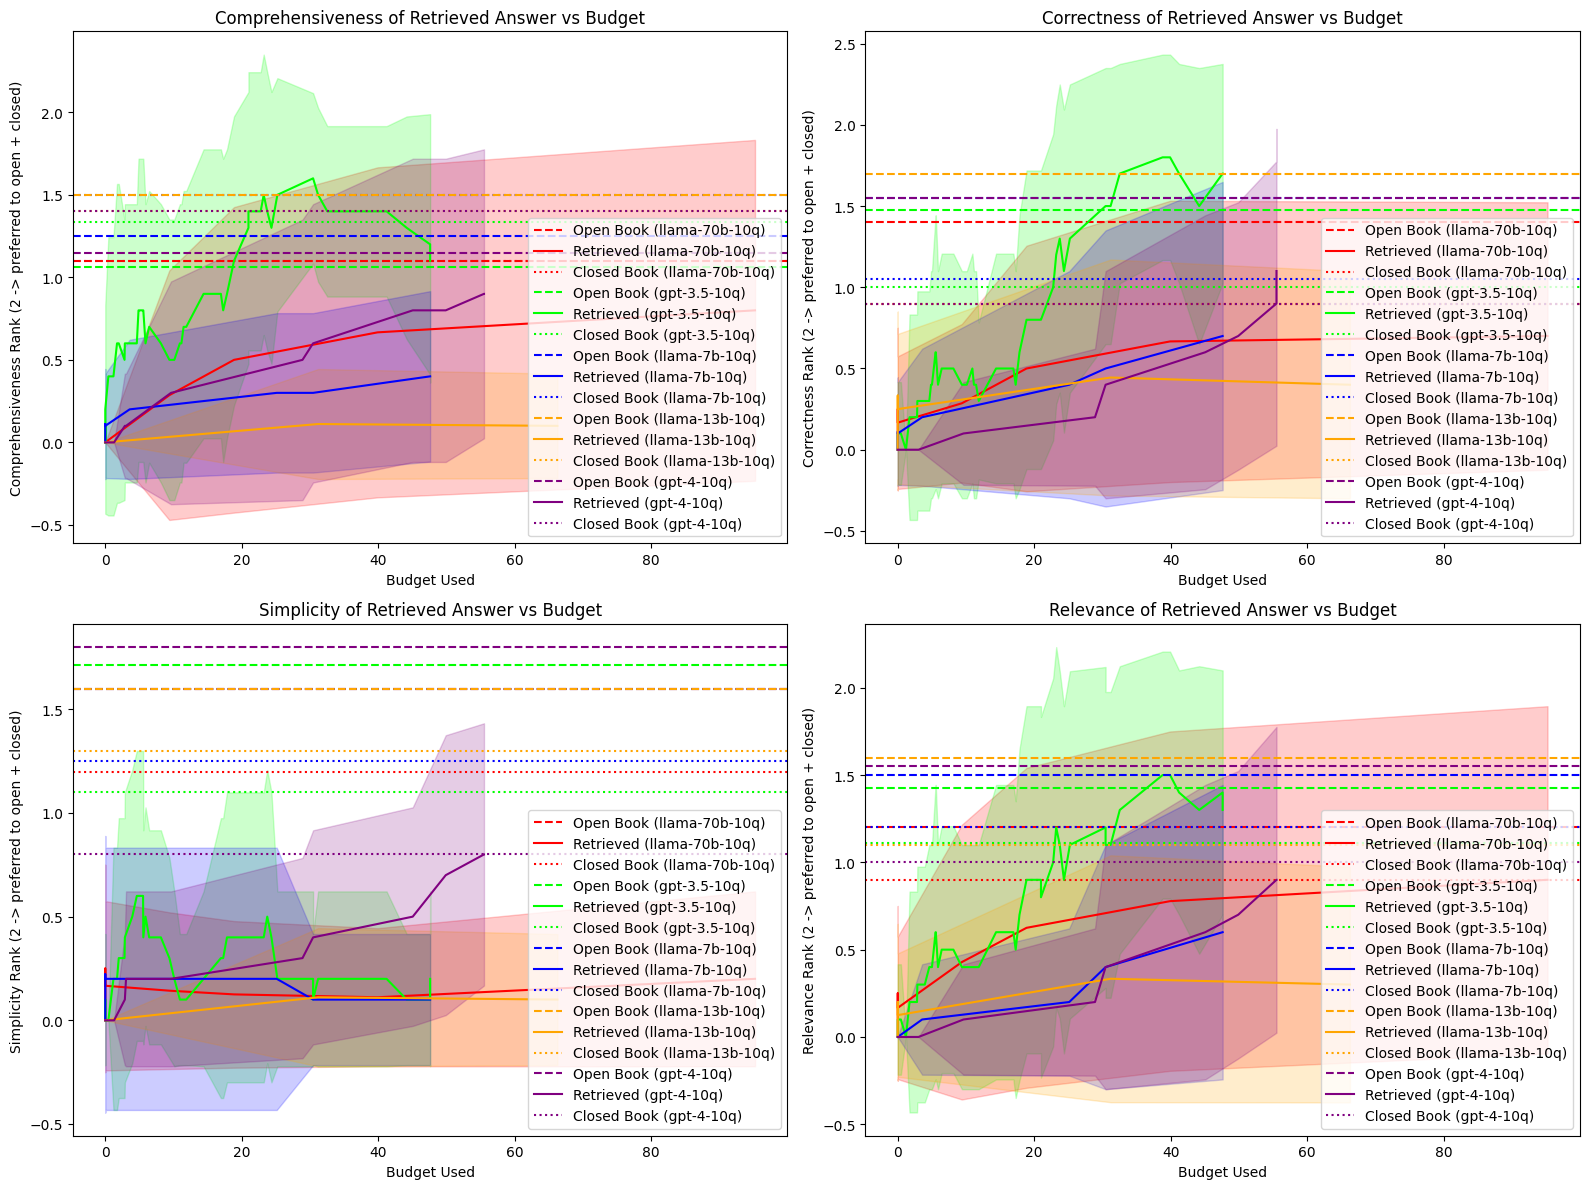

In [9]:
# Calculate budget used
dimensions = ['comprehensiveness', 'correctness', 'simplicity', 'relevance']

# Initialize plot
plt.figure(figsize=(16, 12))
colors = {'llama-70b-10q': '#FF0000',
 'gpt-3.5-10q': '#00FF00',
 'llama-7b-10q': '#0000FF',
 'llama-13b-10q': '#FFA500',
 'gpt-4-10q': '#800080'}

# Loop to create line plots with error bars for each dimension
for i, dim in enumerate(dimensions):
    plt.subplot(2, 2, i+1)
    
    for experiment in df['experiment_name'].unique():
        subset = df[df['experiment_name'] == experiment].sort_values(by='budget_used')
        
        # Calculate running average and standard deviation for retrieved data
        running_mean = subset[f'retrieved_answer_quality/{dim}'].rolling(window=10, min_periods=3).mean()
        running_std = subset[f'retrieved_answer_quality/{dim}'].rolling(window=10, min_periods=3).std()
        
        # Get the mean value of open book data
        open_book_mean = subset[f'open_book_answer_quality/{dim}'].mean()
        
        # Get the mean value of closed book data
        closed_book_mean = subset[f'closed_book_answer_quality/{dim}'].mean()
        
        # Plot a single horizontal line for the mean value of open book quality with the same color as the experiment
        plt.axhline(y=open_book_mean, color=colors[experiment], label=f"Open Book ({experiment})", linestyle='--')
        
        # Plot running average line for retrieved data
        plt.plot(subset['budget_used'], running_mean, color=colors[experiment], label=f"Retrieved ({experiment})")
        
        # Use Seaborn's fill_between for shaded area
        plt.fill_between(subset['budget_used'], running_mean - running_std, running_mean + running_std, color=colors[experiment], alpha=0.2)
        
        # Plot a single horizontal line for the mean value of closed book quality with the same color as the experiment
        plt.axhline(y=closed_book_mean, color=colors[experiment], label=f"Closed Book ({experiment})", linestyle=':')
        

    plt.title(f'{dim.capitalize()} of Retrieved Answer vs Budget')
    plt.xlabel('Budget Used')
    plt.ylabel(f'{dim.capitalize()} Rank (2 -> preferred to open + closed)')
    plt.legend(title='')

plt.tight_layout()
plt.show()


In [11]:
subset[f'retrieved_answer_quality/correctness']

121    0
123    0
124    0
125    0
127    0
136    0
130    0
131    0
132    0
134    0
138    0
135    0
126    0
133    1
128    1
122    2
120    2
137    1
129    2
139    2
Name: retrieved_answer_quality/correctness, dtype: int64

In [12]:
subset.columns

Index(['experiment_name', 'seed', 'name', 'question_text', 'max_budget',
       'credit_left', 'successfully_answered', 'answer_text',
       'gold_block_ware_specs', 'gold_block_content', 'gold_block_rejected',
       'retrieved_answer_quality/comprehensiveness',
       'retrieved_answer_quality/correctness',
       'retrieved_answer_quality/simplicity',
       'retrieved_answer_quality/relevance',
       'open_book_answer_quality/comprehensiveness',
       'open_book_answer_quality/correctness',
       'open_book_answer_quality/simplicity',
       'open_book_answer_quality/relevance',
       'closed_book_answer_quality/comprehensiveness',
       'closed_book_answer_quality/correctness',
       'closed_book_answer_quality/simplicity',
       'closed_book_answer_quality/relevance', 'open_book_answer',
       'closed_book_answer', 'num_block', 'budget_used'],
      dtype='object')

NameError: name 'df_new' is not defined

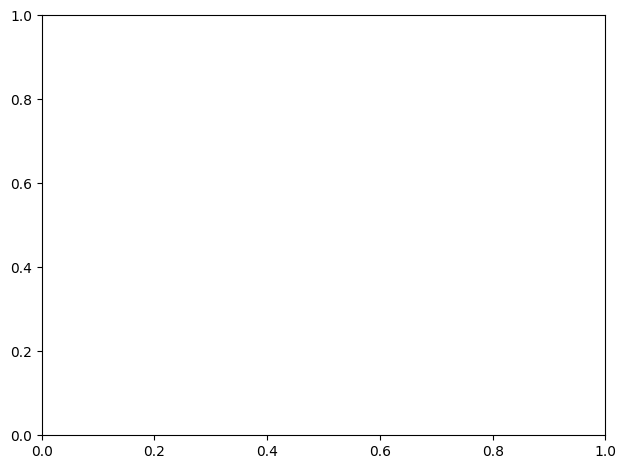

In [13]:
plt.figure(figsize=(16, 12))
colors = {'llama-70b-10q': 'blue', 'gpt-3.5-10q': 'orange'}
param_counts = {'llama-70b-10q': 70_000_000_000, 'gpt-3.5-10q': 175_000_000_000}

# Loop to create scatterplots for each dimension
for i, dim in enumerate(dimensions):
    plt.subplot(2, 2, i+1)
    
    for experiment in df_new['experiment_name'].unique():
        # Filter data for the current dimension and experiment
        subset = df_new[df_new['experiment_name'] == experiment]
        
        # Group and calculate the mean quality for open book and closed book over budget values
        open_book = subset[f'open_book_answer_quality/{dim}']
        closed_book = subset[f'closed_book_answer_quality/{dim}']
        x_val =np.array(param_counts[experiment]).repeat(open_book.shape[0])
        # Plot scatter points for averaged open book quality with the same color as the experiment
        plt.scatter(x_val, open_book, color=colors[experiment], label=f"Open Book ({experiment})")
        
        # Plot scatter points for averaged closed book quality with the same color as the experiment
        plt.scatter(x_val, closed_book, marker='x', color=colors[experiment], label=f"Closed Book ({experiment})")
        

    plt.title(f'Quality vs Budget for {dim.capitalize()} (Averaged Over Budget)')
    plt.xlabel('Param Count')
    plt.ylabel(f'Average {dim.capitalize()}')
    plt.legend(title='Experiment')

plt.tight_layout()
plt.show()
